# Telecom Churn Forecasting with Machine Learning

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math
import time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
contract = pd.read_csv('contract.csv')

contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.duplicated().sum()

0

In [5]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors="coerce").fillna(0.0)

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


The contract dataset has 7043 entries with 8 columns. There were some empty values in the column 'TotalCharges', we replaced them with 0.0. The empty values are from service start date begining on 2020-02-01. There are no duplicated values.

In [8]:
internet = pd.read_csv('internet.csv')

internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.duplicated().sum()

0

The internet dataset has 5517 entries and 8 columns. There are no missing or duplicated values.

In [11]:
personal = pd.read_csv('personal.csv')

personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [14]:
personal.duplicated().sum()

0

The personal dataset has 7043 entries and 5 columns. There are no missing or duplicated values.

In [15]:
phone = pd.read_csv('phone.csv')

phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
phone.duplicated().sum()

0

The phone dataset has 6361 entries and 2 columns. There are no missing or duplicated values.

In [18]:
# Merge datasets in to one

df = (contract
    .merge(internet, how='left', on='customerID')
    .merge(personal, how='left', on='customerID')
    .merge(phone, how='left', on='customerID'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


We merged our data in to one dataset. There are some missing values with internet services and multiple phone lines. this is from customers not having these services. We can replace these missing values with 'no' for no service.

In [19]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [20]:
df['InternetService'] = df['InternetService'].fillna('No Service')

In [21]:
df = df.fillna('No')

In [22]:
df["churn"] = (df["EndDate"]!="No").astype("int")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [24]:
df.loc[df['EndDate'] == 'No',  'EndDate'] = pd.to_datetime('2020-02-01 00:00:00')

df["days"] =  (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days

In [25]:
df_final = df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

We replaced the 'EndDate' and 'BeginDate' columns with a 'churn column. If the customer is still with the company the churn value will be 0 and if they have left the service the value will be 1.

In [26]:
display(df_final.head())

df_final.info()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,days
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,0,31
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1,61


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  gender            7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
 14  Partner           7043 non-null   object 
 15  Dependents        7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


<AxesSubplot:xlabel='churn', ylabel='count'>

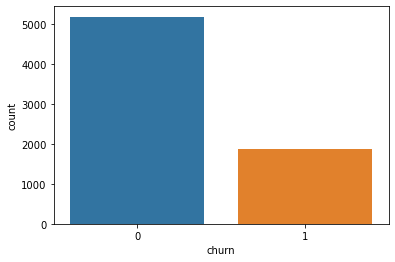

In [27]:
sns.countplot(df_final['churn'])

The churn column is unbalanced.

**Conclusion**

We had 4 datasets: contract, internet, personal, and phone. We merged the datasets together on the customerID column. The missing data from merging datasets was from no internet services. We replaced missing data with the value 'No'. There was empty data entries in the column TotalCharges from customers starting service after data was collected. We empty values with '0.0'. We added a churn column for customers that have left the company. The churn data will be used as our target for model training. The data in the churn column is unbalanced. We will need to balance it before training.

## Exploratory Data Analysis

<AxesSubplot:>

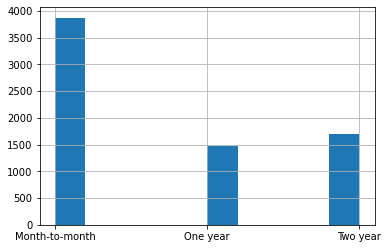

In [28]:
df_final['Type'].hist()

Most customers are have month-to-month service.

<AxesSubplot:>

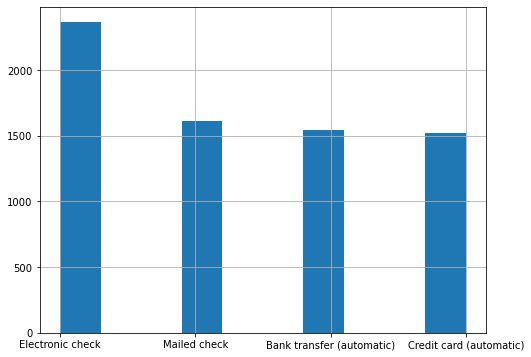

In [29]:
df_final['PaymentMethod'].hist(figsize=(8,6))

Customers favor paying with electronic check. 

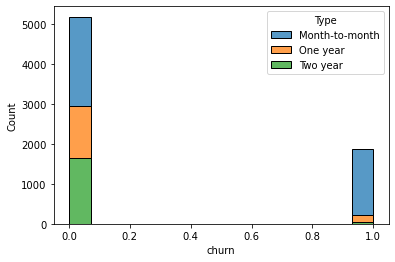

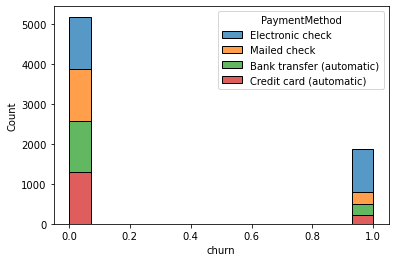

In [30]:
sns.histplot(data=df_final, x="churn", hue='Type', multiple="stack")
plt.show()
sns.histplot(data=df_final, x="churn", hue='PaymentMethod', multiple="stack")
plt.show()

Almost all clients that exit service are month-to-month. The clients that leave mostly use electronic check.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

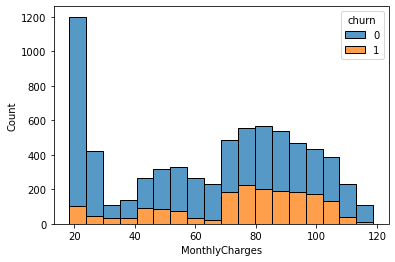

In [31]:
sns.histplot(data=df_final, x="MonthlyCharges", hue='churn', multiple="stack")

Clients that may between $70 to $110 monthly are more likely to leave service. Clients that pay $20 monthly are more likely to stay in the service.

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

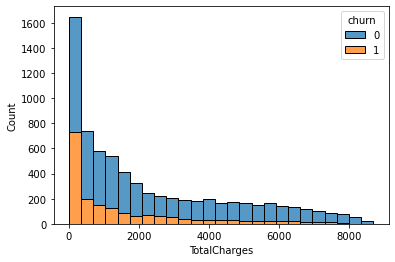

In [32]:
sns.histplot(data=df_final, x="TotalCharges", hue='churn', multiple="stack")

Clients with low total charges are more likely to exit service.

In [33]:
gender_type_churn = df_final.groupby(
    'gender', as_index=False).agg(
    {'churn': 'sum'}).sort_values(
    by='churn', ascending=False, ignore_index=True)

gender_type_churn.head()

,gender,churn
0,Female,939
1,Male,930


About the same amount of males and females are likely to exit service.

In [34]:
dependents_type_churn = df_final.groupby(
    'Dependents', as_index=False).agg(
    {'churn': 'sum'}).sort_values(
    by='churn', ascending=False, ignore_index=True)

dependents_type_churn.head()

,Dependents,churn
0,No,1543
1,Yes,326


Customers with dependents are more likely to stay in service.

In [35]:
internet_type_churn = df_final.groupby(
    'InternetService', as_index=False).agg(
    {'churn': 'sum'}).sort_values(
    by='churn', ascending=False, ignore_index=True)

internet_type_churn.head()

,InternetService,churn
0,Fiber optic,1297
1,DSL,459
2,No Service,113


Customers with internet service are more likely to leave service.

In [36]:
tech_support_type_churn = df_final.groupby(
    'TechSupport', as_index=False).agg(
    {'churn': 'sum'}).sort_values(
    by='churn', ascending=False, ignore_index=True)

tech_support_type_churn.head()

,TechSupport,churn
0,No,1559
1,Yes,310


Customers with tech support are less likely to leave service.

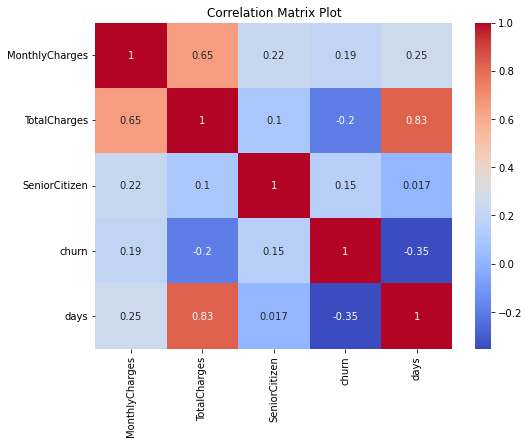

In [37]:
plt.figure(figsize=(8, 6))
corrmatrix = df_final.corr()
sns.heatmap(corrmatrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Plot')
plt.show();

**Conclusion**

Based on our exploratory data analysis:

 - We can see that most customers are on a month-to-month payment. 
 - Clients most likely to leave the service are on a month-to-month payment and use electronic checks. 
 - Customers with higher monthly charges are more likely to leave the service. 
 - The higher the total charges of a client the more likely they are to stay in service.
 - Clients with dependents are more likely to stay in service. 
 - Clients with tech support are more likely to stay in service. 

**Work Plan**

 - We will label the features and target of our data.
 - We will use encoding on our categorical features to change them to numerical values.
 - Before we create and test models we need to look at the balance of classes. We already stated that the churn column is unbalanced. we have to balance classes for the model to be accurate.
 - We will use a baseline dummy to compare our results to.
 - We will train and test different models to find the one with the best AUC-ROC and accuracy.

## Model Training

In [38]:
#create target and features

features = df_final.drop(['churn'], axis = 1)

target = df_final['churn']

display(features.shape)
display(target.shape)

(7043, 18)

(7043,)

In [39]:
#split data in to training and testing sets

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, random_state = 12345)

display(features_train.shape)
display(features_test.shape)

(5282, 18)

(1761, 18)

In [40]:
# ordinal encoding
train_ordinal_features = features_train.copy()
test_ordinal_features = features_test.copy()

cat_features = [column for column in features_train.columns if features_train[column].dtype == 'object']
numerical = [column for column in train_ordinal_features.columns if train_ordinal_features[column].dtype in ['float32', 'float64', 'int64', 'int32']]


# apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
train_ordinal_features[cat_features] = ordinal_encoder.fit_transform(train_ordinal_features[cat_features])
test_ordinal_features[cat_features] = ordinal_encoder.transform(test_ordinal_features[cat_features])

scaler = StandardScaler()
scaler.fit(train_ordinal_features[numerical])

train_ordinal_features[numerical] = scaler.transform(train_ordinal_features[numerical])
test_ordinal_features[numerical] = scaler.transform(test_ordinal_features[numerical])

train_ordinal_features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,days
845,1.0,0.0,3.0,-1.475875,-0.885484,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.439162,1.0,1.0,0.0,-0.719651
6386,2.0,1.0,1.0,0.617064,1.674190,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-0.439162,1.0,1.0,1.0,1.609306
1194,0.0,0.0,2.0,-0.482560,-0.678188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.439162,0.0,0.0,0.0,-0.759944
5787,0.0,1.0,2.0,0.749949,0.342904,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,-0.439162,0.0,0.0,0.0,0.137255
3585,1.0,0.0,3.0,0.836324,0.365290,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.277062,1.0,0.0,0.0,0.058011


In [41]:
# one-hot encoding
df_ohe = pd.get_dummies(df_final, drop_first=True)

ohe_features = df_ohe.drop(['churn'], axis=1)
ohe_target = df_ohe['churn']

train_ohe_features, test_ohe_features, train_ohe_target, test_ohe_target = train_test_split(
    ohe_features, ohe_target, test_size=0.25, random_state=12345
)


numerical = [column for column in train_ohe_features.columns if train_ohe_features[column].dtype in ['float32', 'float64', 'int64', 'int32']]

scaler = StandardScaler()
scaler.fit(train_ohe_features[numerical])

train_ohe_features[numerical] = scaler.transform(train_ohe_features[numerical])
test_ohe_features[numerical] = scaler.transform(test_ohe_features[numerical])

test_ohe_features.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes
1128,-1.514079,-0.782233,-0.439162,-0.229415,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2875,0.668557,-0.188868,-0.439162,-0.436254,0,0,1,0,1,0,...,0,0,0,0,0,1,1,1,0,1
1783,0.221731,-0.984518,-0.439162,-1.293160,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
3804,0.494145,-0.664148,-0.439162,-0.922461,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
6087,-0.831383,-0.564142,-0.439162,-0.269708,1,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0


<AxesSubplot:xlabel='churn', ylabel='count'>

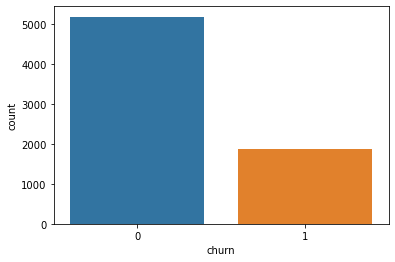

In [42]:
#check class balance

sns.countplot(df_final['churn'])

In [43]:
# downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=123)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=123)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=123
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.359
)

target_downsampled.value_counts()

1    1395
0    1395
Name: churn, dtype: int64

In [44]:
# upsampled train dataset for label encoded trainset
downsampled_train_ordinal_features, downsampled_train_ordinal_target = downsample(
    train_ordinal_features, target_train, 0.359
)

# upsampled train dataset for one-hot encoded data
downsampled_train_ohe_features, downsampled_train_ohe_target = downsample(
    train_ohe_features, train_ohe_target, 0.359
)



In [45]:
# function to evaluate models
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

Before we begin model training we split our data in to a training and testing set. We encoded our categorical features and scaled our numerical features. We balanced our data by using downscaling and created a function to evaluate our models. The data is now ready to be trained on our models.

### Baseline Model

In [46]:
%%time
dummy_model = DummyClassifier(random_state=12345)

dummy_model.fit(features_train, target_train)

Wall time: 0 ns


DummyClassifier(random_state=12345)

          train  test
Accuracy   0.74  0.73
F1         0.00  0.00
APS        0.26  0.27
ROC AUC    0.50  0.50
Wall time: 328 ms


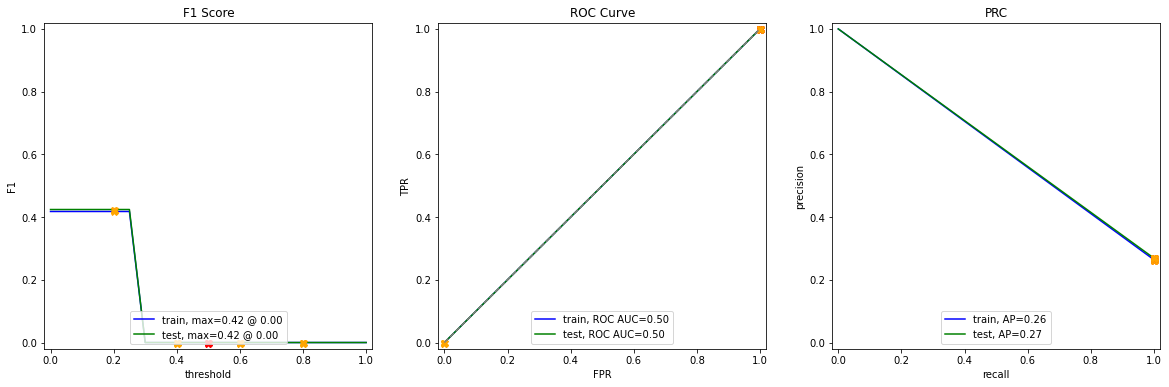

In [47]:
%%time
evaluate_model(dummy_model, features_train, target_train, features_test, target_test)

Our dummy model achieved a roc-auc sore of 50%. This is the baseline for our models.

### Logistic Regression Model

In [48]:
%%time
lr_model = LogisticRegression(random_state = 12345, solver = 'liblinear')

lr_model.fit(train_ohe_features, train_ohe_target)

Wall time: 32 ms


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.81  0.80
F1         0.60  0.60
APS        0.67  0.64
ROC AUC    0.85  0.84
Wall time: 280 ms


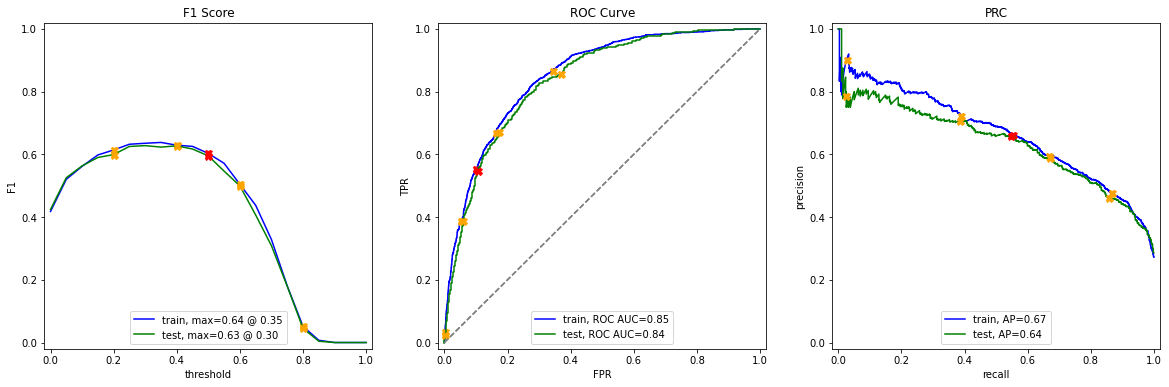

In [49]:
%%time
evaluate_model(lr_model, train_ohe_features, train_ohe_target, test_ohe_features, test_ohe_target)

### Logistic Regression with Downsampling

In [50]:
lr_model_down = LogisticRegression(random_state = 12345, solver = 'liblinear')
lr_model_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.77  0.73
F1         0.78  0.61
APS        0.83  0.62
ROC AUC    0.85  0.83
Wall time: 360 ms


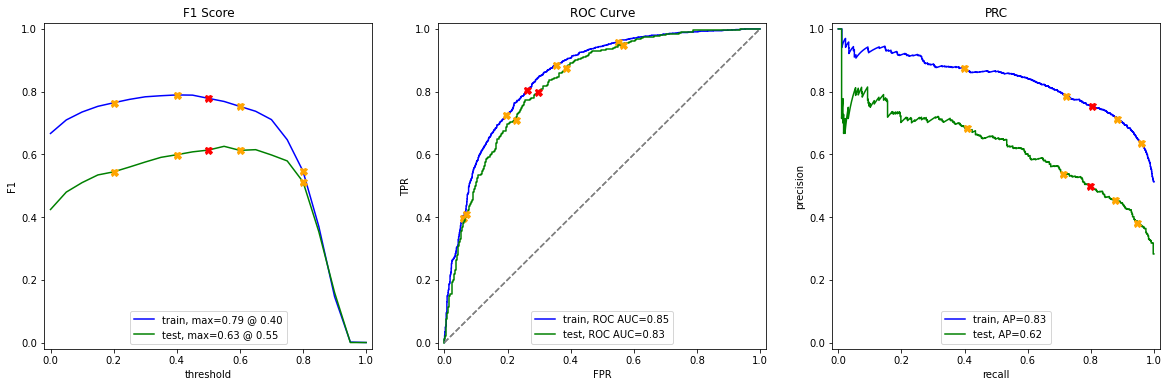

In [51]:
%%time
evaluate_model(lr_model_down, downsampled_train_ordinal_features, downsampled_train_ordinal_target, test_ordinal_features, target_test)

Our logistic regression model had a roc-auc score of 84% before class balance was applied. The score decreased to 83% after class balance.

### Decision Tree Classifier

In [52]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : [None, 2, 4, 8, 10, 12],
    "min_samples_split" : [2, 4, 8, 16, 32],
    "min_samples_leaf" : [2, 4, 6, 8, 10]
}
# define the model 
regressor = DecisionTreeClassifier(random_state = 12345)
# define the grid search
grid_search_dt = GridSearchCV(estimator = regressor, param_grid = grid, scoring="roc_auc", cv=3)
# execute search
dt_cv = grid_search_dt.fit(train_ordinal_features, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(dt_cv.best_params_))

The best hyperparameters are: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
Wall time: 18.4 s


In [53]:
%%time
dt_model = DecisionTreeClassifier(**grid_search_dt.best_params_)

dt_model.fit(train_ordinal_features, target_train)

Wall time: 24 ms


DecisionTreeClassifier(max_depth=4, min_samples_leaf=4)

          train  test
Accuracy   0.81  0.81
F1         0.57  0.57
APS        0.66  0.65
ROC AUC    0.85  0.85
Wall time: 424 ms


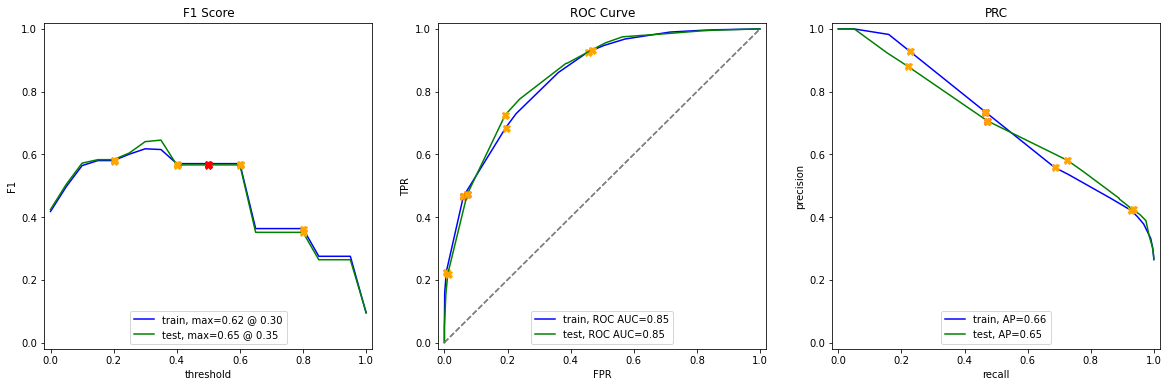

In [54]:
%%time
evaluate_model(dt_model, train_ordinal_features, target_train, test_ordinal_features, target_test)

### Decision Tree with Downsampling

In [55]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "max_depth" : [None, 2, 4, 8, 10, 12],
    "min_samples_split" : [2, 4, 8, 16, 32],
    "min_samples_leaf" : [2, 4, 6, 8, 10]
}
# define the model 
regressor = DecisionTreeClassifier(random_state = 12345)
# define the grid search
grid_search_dt_down = GridSearchCV(estimator = regressor, param_grid = grid, scoring="roc_auc", cv=5)
# execute search
grid_search_dt_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_dt_down.best_params_))

The best hyperparameters are: {'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 32}
Wall time: 11.4 s


In [56]:
%%time
dt_model_down = DecisionTreeClassifier(**grid_search_dt_down.best_params_)

dt_model_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target)

Wall time: 16 ms


DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=32)

          train  test
Accuracy   0.82  0.74
F1         0.82  0.62
APS        0.90  0.66
ROC AUC    0.91  0.83
Wall time: 488 ms


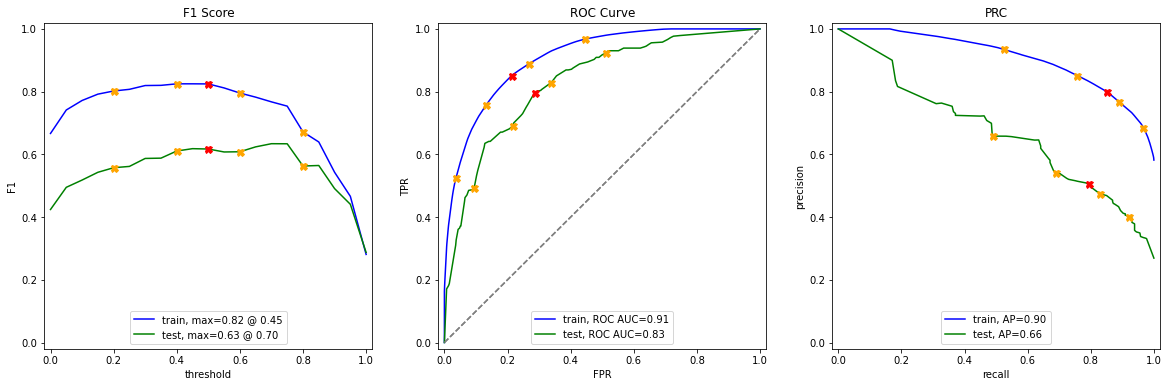

In [57]:
%%time
evaluate_model(dt_model_down, downsampled_train_ordinal_features, downsampled_train_ordinal_target, test_ordinal_features, target_test)

Our decision tree model has a roc-auc score of 85% before applying class balance and an 83% after class balance.

### Random Forest Classifier

In [58]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "criterion" : ["gini", "entropy"],
    "n_estimators" : [10, 25, 50, 100],
    "max_depth" : [None, 2 , 6, 10],
    "min_samples_leaf" : [2, 4, 6]
}
# define the model 
regressor = RandomForestClassifier(random_state = 12345)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring="roc_auc", cv=5)
# execute search
rf_cv = grid_search_rf.fit(train_ordinal_features, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(rf_cv.best_params_))

The best hyperparameters are: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Wall time: 1min 59s


In [59]:
%%time
rf_model = RandomForestClassifier(**grid_search_rf.best_params_)

rf_model.fit(train_ordinal_features, target_train)

Wall time: 744 ms


RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2)

          train  test
Accuracy   0.87  0.81
F1         0.72  0.59
APS        0.87  0.72
ROC AUC    0.95  0.86
Wall time: 496 ms


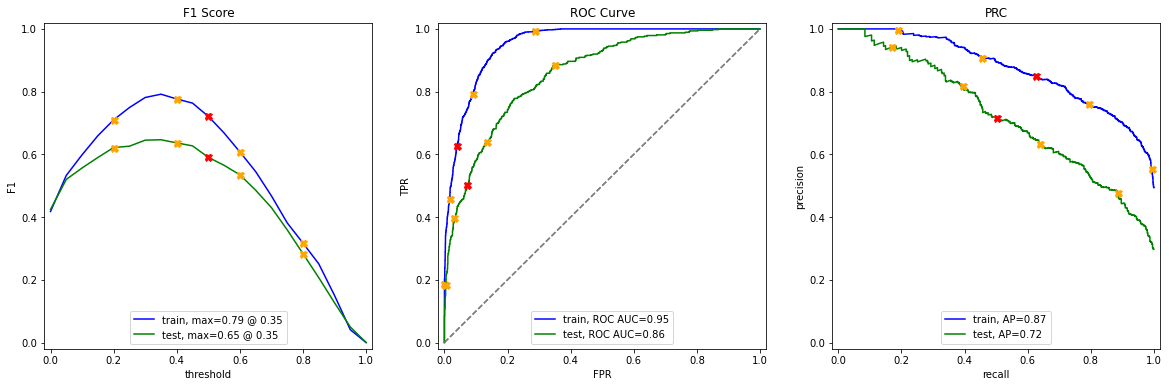

In [60]:
%%time
evaluate_model(rf_model, train_ordinal_features, target_train, test_ordinal_features, target_test)

### Random Forest with Downsampling

In [61]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "n_estimators" : [10, 25, 50, 100],
    "max_depth" : [None, 2 , 6, 10],
    "min_samples_leaf" : [2, 4, 6]
}
# define the model 
regressor = RandomForestClassifier(random_state = 12345)
# define the grid search
grid_search_rf_down = GridSearchCV(estimator = regressor, param_grid = grid, scoring="roc_auc", cv=5)
# execute search
grid_search_rf_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf_down.best_params_))

The best hyperparameters are: {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 100}
Wall time: 34 s


In [62]:
%%time
rf_model_down = RandomForestClassifier(**grid_search_rf_down.best_params_)

rf_model_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target)

Wall time: 392 ms


RandomForestClassifier(max_depth=10, min_samples_leaf=6)

          train  test
Accuracy   0.85  0.75
F1         0.85  0.63
APS        0.93  0.68
ROC AUC    0.93  0.85
Wall time: 400 ms


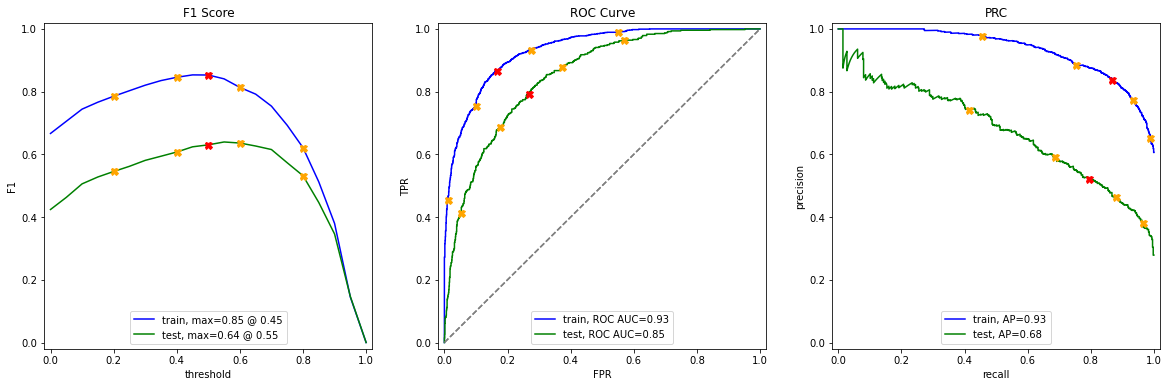

In [63]:
%%time
evaluate_model(rf_model_down, downsampled_train_ordinal_features, downsampled_train_ordinal_target, test_ordinal_features, target_test)

Our random forest model had a roc-auc score of 86% before class balance. The  roc-auc score was 85% after downsampling was applied.

### CatBoost Classifier

In [64]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {'learning_rate': [0.01, 0.1, 0.5],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 5]
       }
# define the model 
cb_regr = CatBoostClassifier(
    iterations=100,
    cat_features=cat_features,
    logging_level = 'Silent',
    loss_function = 'Logloss',
    early_stopping_rounds = 50,
    random_state = 12345)
# define the grid search
grid_search_cb = GridSearchCV(estimator = cb_regr, param_grid = grid, scoring="roc_auc", cv=5)
# execute search
grid_search_cb.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_cb.best_params_))

The best hyperparameters are: {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.5}
Wall time: 1min 41s


In [65]:
%%time
cb_model = CatBoostClassifier(**grid_search_cb.best_params_)

cb_model.fit(features_train, target_train, eval_set=(features_test, target_test), cat_features=cat_features, verbose = False)

Wall time: 19.2 s


          train  test
Accuracy   0.93  0.88
F1         0.85  0.76
APS        0.94  0.86
ROC AUC    0.97  0.92
Wall time: 352 ms


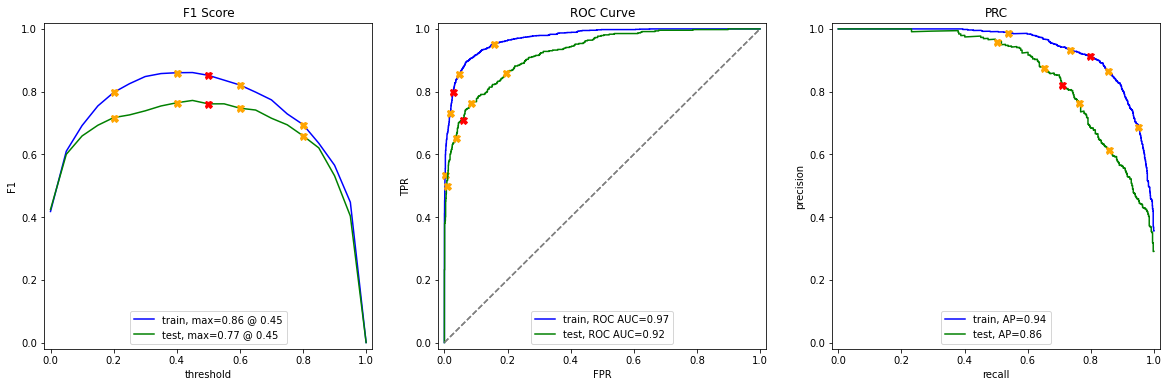

In [66]:
%%time
evaluate_model(cb_model, features_train, target_train, features_test, target_test)

### CatBoost with Downsampling

In [67]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {'learning_rate': [0.01, 0.1, 0.5],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 5]
       }
# define the model 
cb_regr = CatBoostClassifier(
    iterations=100,
    cat_features=cat_features,
    logging_level = 'Silent',
    loss_function = 'Logloss',
    early_stopping_rounds = 50,
    random_state = 12345)
# define the grid search
grid_search_cb_down = GridSearchCV(estimator = cb_regr, param_grid = grid, scoring="roc_auc", cv=5)
# execute search
grid_search_cb_down.fit(features_downsampled, target_downsampled)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_cb_down.best_params_))

The best hyperparameters are: {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.5}
Wall time: 1min 30s


In [68]:
%%time
cb_model_down = CatBoostClassifier(**grid_search_cb_down.best_params_)

cb_model_down.fit(features_downsampled, target_downsampled, eval_set=(features_test, target_test), cat_features=cat_features, verbose = False)

Wall time: 14.8 s


          train  test
Accuracy   0.88  0.81
F1         0.88  0.70
APS        0.95  0.81
ROC AUC    0.95  0.90
Wall time: 416 ms


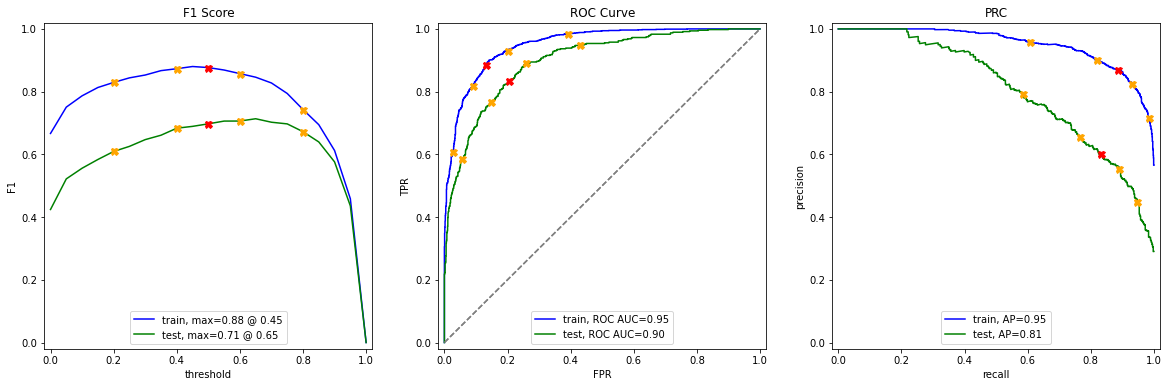

In [69]:
%%time
evaluate_model(cb_model_down, features_downsampled, target_downsampled, features_test, target_test)

The roc-auc score for our catboost model before class balance was 92%, after downsampling was applied the roc-auc score was 90%.

### LightGBM Classifier

In [70]:
%%time
# hyperparameter optimization for LightGBM regression

# define hyperparameters to tune
lgbm_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
             'n_estimators': [50, 100, 150, 250],
             'num_leaves': [5, 10, 15, 25]
            }
# define the model 
lgbm_regr = LGBMClassifier(random_state = 12345)

# define the grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "roc_auc", 
    cv = 3, 
    n_jobs = 1
)
# execute search
grid_search_lgbm.fit(train_ordinal_features, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_lgbm.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'n_estimators': 250, 'num_leaves': 15}
Wall time: 31.5 s


In [71]:
%%time
lgbm_model = LGBMClassifier(**grid_search_lgbm.best_params_)

lgbm_model.fit(train_ordinal_features, target_train)

Wall time: 392 ms


LGBMClassifier(n_estimators=250, num_leaves=15)

          train  test
Accuracy   0.93  0.86
F1         0.87  0.70
APS        0.96  0.81
ROC AUC    0.98  0.90
Wall time: 634 ms


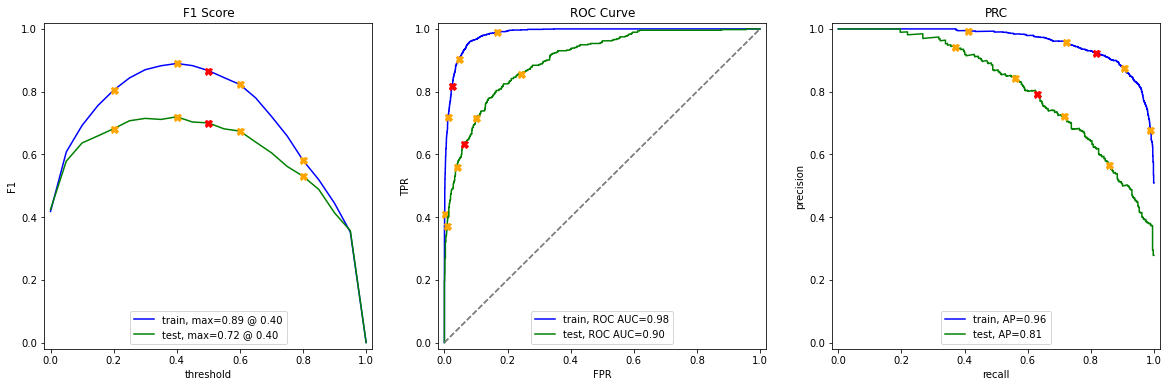

In [72]:
%%time
evaluate_model(lgbm_model, train_ordinal_features, target_train, test_ordinal_features, target_test)

### LightGBM with Downsampling

In [73]:
%%time
# hyperparameter optimization for LightGBM regression

# define hyperparameters to tune
lgbm_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
             'n_estimators': [50, 100, 150, 250],
             'num_leaves': [5, 10, 15, 25]
            }
# define the model 
lgbm_regr = LGBMClassifier(random_state = 12345)

# define the grid search
grid_search_lgbm_down = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "roc_auc", 
    cv = 3, 
    n_jobs = 1
)
# execute search
grid_search_lgbm_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target, categorical_feature = 'auto', feature_name = 'auto')
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_lgbm_down.best_params_))

The best hyperparameters are: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 10}
Wall time: 31.9 s


In [74]:
%%time
lgbm_model_down = LGBMClassifier(**grid_search_lgbm_down.best_params_)

lgbm_model_down.fit(downsampled_train_ordinal_features, downsampled_train_ordinal_target)

Wall time: 160 ms


LGBMClassifier(learning_rate=0.05, n_estimators=150, num_leaves=10)

          train  test
Accuracy   0.83  0.78
F1         0.83  0.67
APS        0.93  0.75
ROC AUC    0.92  0.88
Wall time: 440 ms


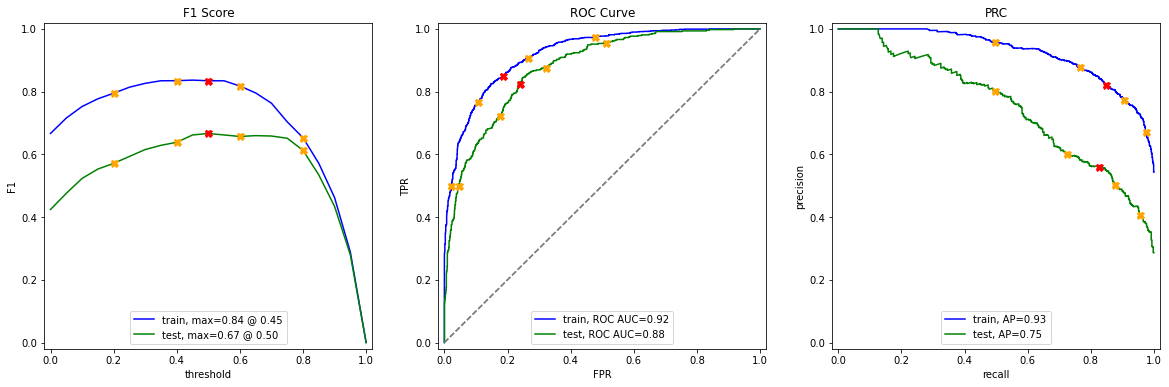

In [75]:
%%time
evaluate_model(lgbm_model_down, downsampled_train_ordinal_features, downsampled_train_ordinal_target, test_ordinal_features, target_test)

Our lightgbm model had a roc-auc score of 90% before class balance and a 88% after downsampling was applied.

### XGBoost Classifier

In [76]:
%%time
# hyperparameter optimization for XGBoost Classifier

# define hyperparameters to tune
grid_xgb = {'learning_rate': [0.001, 0.01, 0.1], 
            'max_depth': [2, 4, 6],
            'n_estimators': [50, 100, 150]
           }
# define the model 
xgb_clf = XGBClassifier(random_state = 12345, verbosity = 0)
# define the grid search
grid_search_xgb = GridSearchCV(
    estimator = xgb_clf, 
    param_grid = grid_xgb, 
    scoring = "roc_auc", 
    cv = 5, 
    n_jobs = 1
)
# execute search
xgb_cv = grid_search_xgb.fit(train_ohe_features, train_ohe_target)
# summarize result
print('The best hyperparameters are: {}'.format(xgb_cv.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}
Wall time: 1min 13s


In [77]:
%%time
xgb_model = XGBClassifier(**grid_search_xgb.best_params_)

xgb_model.fit(train_ohe_features, train_ohe_target)

Wall time: 1.15 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

          train  test
Accuracy   0.92  0.85
F1         0.83  0.68
APS        0.94  0.80
ROC AUC    0.97  0.89
Wall time: 440 ms


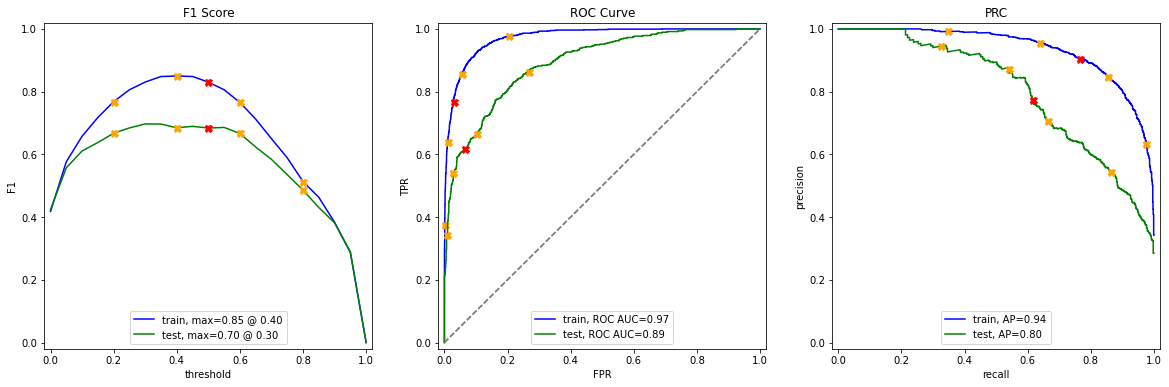

In [78]:
%%time
evaluate_model(xgb_model, train_ohe_features, train_ohe_target, test_ohe_features, test_ohe_target)

### XGBoost with Downsampling

In [79]:
%%time
# hyperparameter optimization for XGBoost Classifier

# define hyperparameters to tune
grid_xgb = {'learning_rate': [0.001, 0.01, 0.1], 
            'max_depth': [2, 4, 6],
            'n_estimators': [50, 100, 150]
           }
# define the model 
xgb_clf = XGBClassifier(random_state = 12345, verbosity = 0)
# define the grid search
grid_search_xgb_down = GridSearchCV(
    estimator = xgb_clf, 
    param_grid = grid_xgb, 
    scoring = "roc_auc", 
    cv = 5, 
    n_jobs = 1
)
# execute search
grid_search_xgb_down.fit(downsampled_train_ohe_features, downsampled_train_ohe_target)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_xgb_down.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}
Wall time: 49.5 s


In [80]:
%%time
xgb_model_down = XGBClassifier(**grid_search_xgb_down.best_params_)

xgb_model_down.fit(downsampled_train_ohe_features, downsampled_train_ohe_target)

Wall time: 648 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

          train  test
Accuracy   0.87  0.79
F1         0.87  0.67
APS        0.95  0.76
ROC AUC    0.95  0.88
Wall time: 432 ms


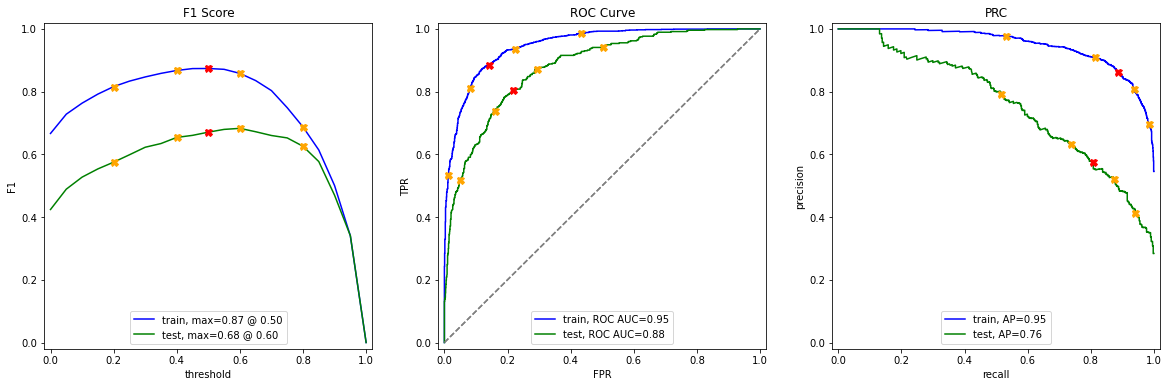

In [81]:
%%time
evaluate_model(xgb_model_down, downsampled_train_ohe_features, downsampled_train_ohe_target, test_ohe_features, test_ohe_target)

Our xgboost model had a roc-auc score of 89% before class balance. After downsampling was applied the roc-auc score dropped to 88%.

**Conclusion**

We used multiple model with and without class balance to train our data. We encoded our categorical features and scaled our numerical features. We created a function to evaluate our models for roc-auc, f1, accuracy, and aps scores. We also graphed the f1 score curve, roc curve, and prc curve. We used downsampling to balance our data. The roc-auc score of the models with downsampling was lower than the ones without class balance. Our baseline model had an roc-auc score of 50%. The highest roc-auc score of 92% was obtained with our catboost model.

## Model Testing

          train  test
Accuracy   0.93  0.88
F1         0.85  0.76
APS        0.94  0.86
ROC AUC    0.97  0.92
Wall time: 472 ms


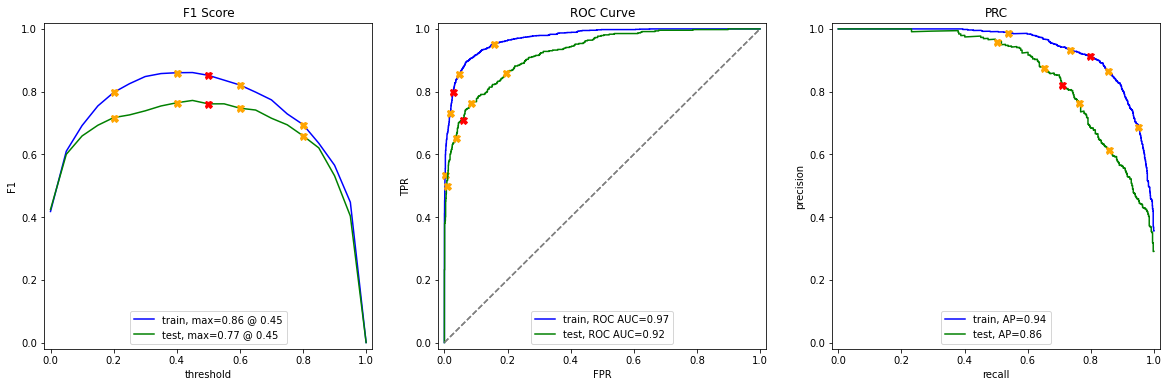

In [82]:
%%time
evaluate_model(cb_model, features_train, target_train, features_test, target_test)

The catboost model without downsampling was chosen for model testing because it had the highest roc-auc score of 92%.

## Solution Report

We merged our four orginal datasets in to one. We replaced all missing values in the merged dataset. The missing values were due to clients not having internet services or multiple phone lines. We added a 'churn' column for customers that have left service. We added a 'days' column with the number of days a client has been in service. Without the 'days' feature we could not achieve an roc-auc score high enough to reach our threshold of 88%. 

From exploratory data analysis we found that:
 - most customers are on a month-to-month payment 
 - clients most likely to leave the service are on a month-to-month payment and use electronic checks and have higher monthly      charges 
 - customers with a higher total charge stay in service
 - clients with tech support services churn less
 
 
 We followed every step of our goal plan. We labeled our features and target of our data. We split our data in to a train and test set. The test set was 25% of our data. We used encoding on our categorical features by using one-hot encoding and ordinal encoding. One-hot encoding was used for logistic regression and xgboost models. Ordinal encoding was used for decision tree, random forest, and lightgbm models. Catboost has it's own categorical encoding feature. We scaled all numerical values. Downsampling was used to balance classes. Our dummy model had an roc-auc score of 50%. This will be used as our baseline. We checked all models with and without class balance. We found that models were more accurate without downsampling. Our best model was the catboost algorithm. The catboost algorithm achieved a roc-auc score of 92% and an accuracy score of 88%. We were able to find the best model to forecast the churn of clients.